Step 1 – Load dataset & basic setup

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [14]:
# File Path
BASE_DIR = Path().resolve().parents[1]

INPUT_PATH = BASE_DIR / "data" / "processed" / "final_arctic.csv"

In [15]:
df_raw = pd.read_csv(INPUT_PATH)

# Create date column
df_raw["year"] = df_raw["year"].astype(int)
df_raw["month"] = df_raw["month"].astype(int)
df_raw["date"] = pd.to_datetime(dict(year=df_raw["year"], month=df_raw["month"], day=1))
df_raw = df_raw.sort_values("date")

TARGET = "sia_million_km2"

# Basic info
print("[INFO] Shape:", df_raw.shape)
print(df_raw.head())
print("\n[NaN % by column]")
print((df_raw.isna().mean()*100).round(2))

[INFO] Shape: (543, 20)
   year  month  sia_million_km2  sie_million_km2    thick_m          cdir  \
0  1978     10         9.524144        10.153839        NaN  793575.44000   
1  1978     11        10.811478        11.506771        NaN   42043.16400   
2  1978     12        12.834232        13.668629        NaN     137.44655   
3  1979      1        14.615531        15.543609  3973.8833   10864.35900   
4  1979      2        15.492461        16.448393  3973.9478  352633.30000   

             uvb       slhf        sf        t2m        sst      istl1  \
0  110108.530000 -923622.06  0.000985  260.21402  272.12772  263.60452   
1    8703.622000 -821054.06  0.000860  253.88397  271.93120  259.63235   
2      67.879295 -621884.70  0.000541  249.05974  271.80540  255.64603   
3    2573.583700 -675217.70  0.000611  248.04901  271.73035  255.39026   
4   55168.465000 -591981.30  0.000524  243.43956  271.68857  251.93723   

       istl2      istl3      istl4        skt      ishf       tcc   

Step 2 – Light, in-memory fill for EDA plots

In [16]:
# Make a working copy for EDA (keeps df_raw untouched)
df_eda = df_raw.set_index("date").copy()

# Helper for month-aware fill
def monthaware_fill(s: pd.Series, months: pd.Series) -> pd.Series:
    clim = s.groupby(months).median()
    out = s.copy()
    out = out.fillna(months.map(clim))
    out = out.interpolate(method="time", limit_direction="both")
    if out.isna().any():
        out = out.fillna(out.median())
    return out

# Fill ice thickness
if "thick_m" in df_eda.columns:
    df_eda["thick_m"] = monthaware_fill(df_eda["thick_m"], df_eda["month"]).clip(lower=0)

# Fill other numeric cols for correlation/pairplots
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if c not in {TARGET, "thick_m", "year", "month"}:
        s = df_eda[c]
        s = s.interpolate(method="time", limit_direction="both")
        if s.isna().any():
            s = s.fillna(df_eda["month"].map(s.groupby(df_eda["month"]).median()))
        if s.isna().any():
            s = s.fillna(s.median())
        df_eda[c] = s

df_eda = df_eda.reset_index()
print("\n[NaN % after fill in df_eda]")
print((df_eda.isna().mean()*100).round(2))


[NaN % after fill in df_eda]
date               0.0
year               0.0
month              0.0
sia_million_km2    0.0
sie_million_km2    0.0
thick_m            0.0
cdir               0.0
uvb                0.0
slhf               0.0
sf                 0.0
t2m                0.0
sst                0.0
istl1              0.0
istl2              0.0
istl3              0.0
istl4              0.0
skt                0.0
ishf               0.0
tcc                0.0
tsn                0.0
dtype: float64


In [18]:
# Summary stats for raw data
print("\n[SUMMARY STATS – Raw Data]")
print(df_raw.select_dtypes(include=[np.number]).describe().T)

# Summary stats for EDA copy
print("\n[SUMMARY STATS – EDA Copy]")
print(df_eda.select_dtypes(include=[np.number]).describe().T)


[SUMMARY STATS – Raw Data]
                 count          mean           std           min  \
year             543.0  2.000873e+03  1.307502e+01  1.978000e+03   
month            543.0  6.524862e+00  3.462347e+00  1.000000e+00   
sia_million_km2  543.0  1.035507e+01  3.363172e+00  6.422494e-01   
sie_million_km2  543.0  1.127242e+01  3.446321e+00  7.379435e-01   
thick_m          528.0  3.973422e+03  2.766642e-01  3.972820e+03   
cdir             543.0  8.274747e+06  9.111756e+06  7.220023e+01   
uvb              543.0  9.740743e+05  1.064230e+06  5.292351e+01   
slhf             543.0 -9.702590e+05  2.645493e+05 -1.819735e+06   
sf               543.0  6.695240e-04  1.756669e-04  1.276206e-04   
t2m              543.0  2.613284e+02  1.017783e+01  2.434396e+02   
sst              543.0  2.722446e+02  5.436512e-01  2.716886e+02   
istl1            543.0  2.639576e+02  6.483926e+00  2.519372e+02   
istl2            543.0  2.645845e+02  5.970753e+00  2.535338e+02   
istl3            543

Step 4 – Trend plots

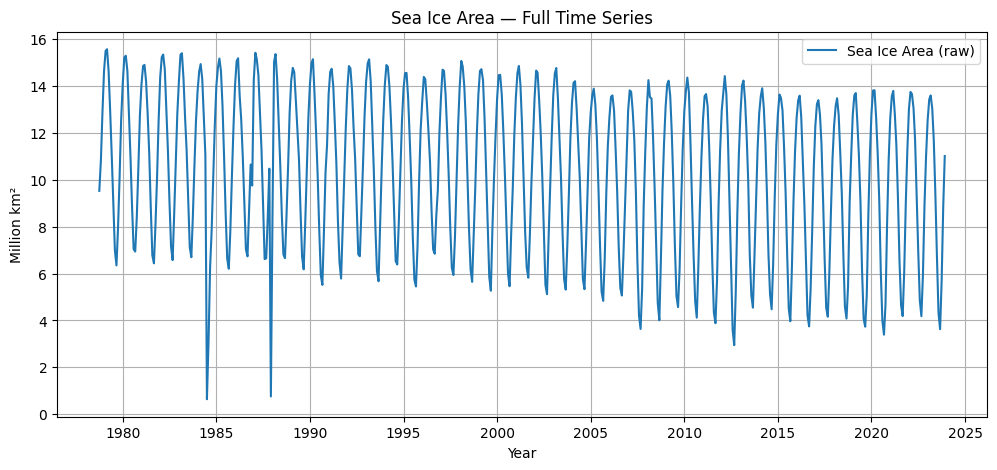

In [20]:
# Full time series (raw)
plt.figure(figsize=(12,5))
plt.plot(df_raw["date"], df_raw[TARGET], label="Sea Ice Area (raw)")
plt.title("Sea Ice Area — Full Time Series")
plt.xlabel("Year")
plt.ylabel("Million km²")
plt.grid(True)
plt.legend()
plt.show()

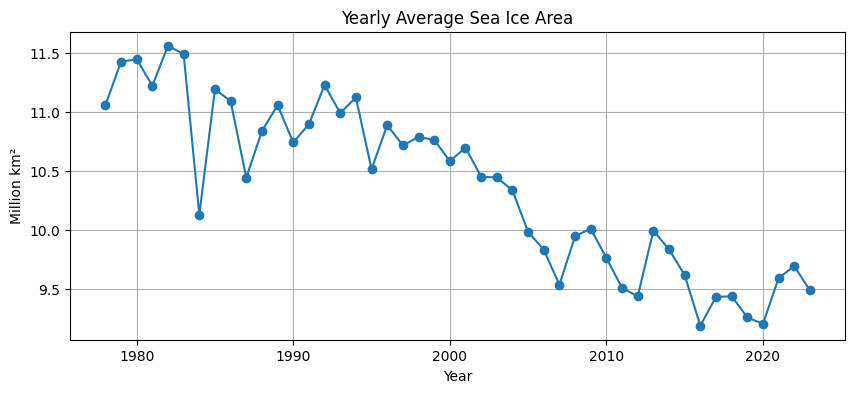

In [21]:
# Yearly average
yearly_mean = df_raw.groupby("year")[TARGET].mean()
plt.figure(figsize=(10,4))
plt.plot(yearly_mean.index, yearly_mean.values, marker='o')
plt.title("Yearly Average Sea Ice Area")
plt.xlabel("Year")
plt.ylabel("Million km²")
plt.grid(True)
plt.show()

Step 5 - Seasonality

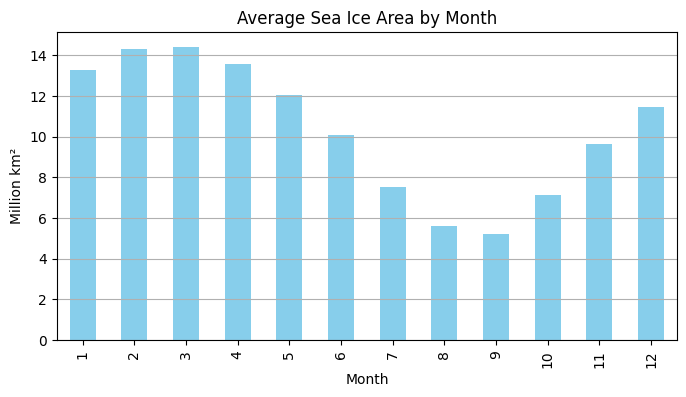

In [22]:
monthly_clim = df_raw.groupby("month")[TARGET].mean()

plt.figure(figsize=(8,4))
monthly_clim.plot(kind="bar", color="skyblue")
plt.title("Average Sea Ice Area by Month")
plt.xlabel("Month")
plt.ylabel("Million km²")
plt.grid(axis="y")
plt.show()

Step 6 -  Correlation Analysis

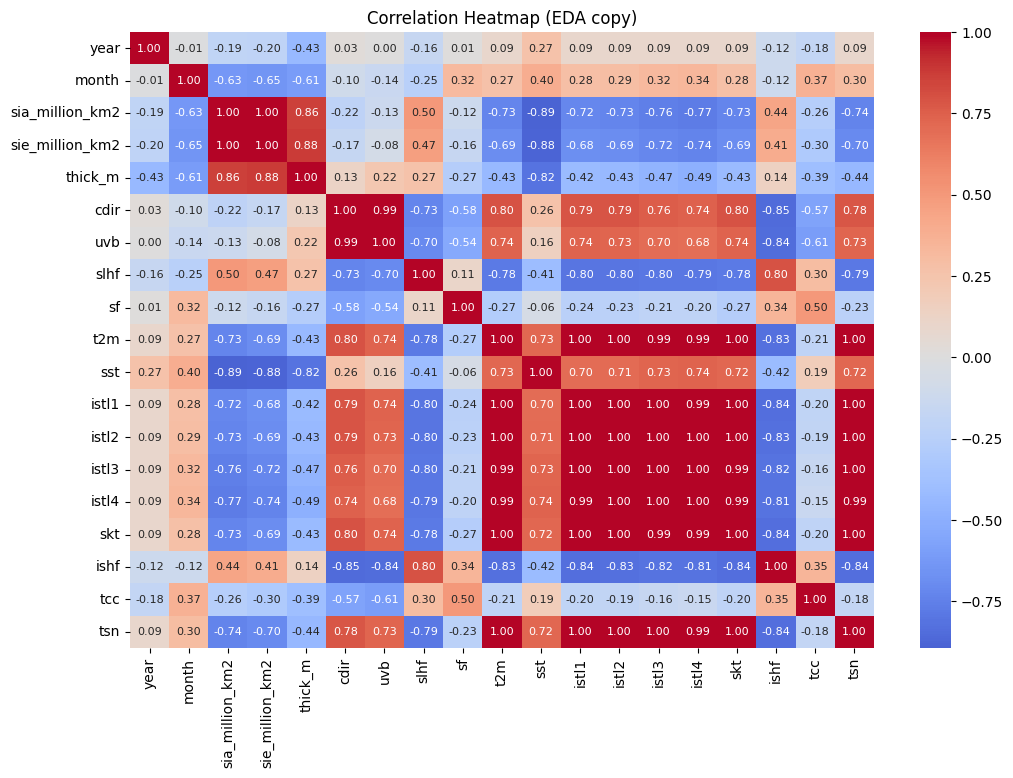

In [27]:
# Select only numeric columns for correlation
num_cols_eda = df_eda.select_dtypes(include=[np.number]).columns
corr = df_eda[num_cols_eda].corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,        # <-- show values inside cells
    fmt=".2f",         # <-- 2 decimal places
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 8}  # text size inside boxes
)
plt.title("Correlation Heatmap (EDA copy)")
plt.show()


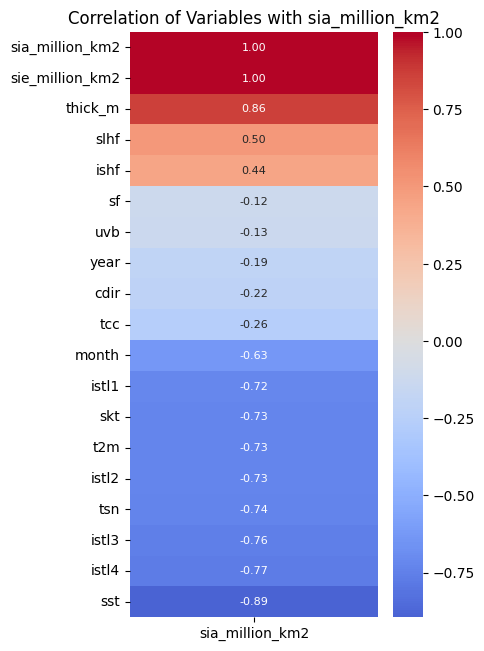

In [29]:
# --- 2) Target-only correlation heatmap ---
target_corr = corr[[TARGET]].sort_values(by=TARGET, ascending=False)

plt.figure(figsize=(4, len(target_corr) * 0.4))
sns.heatmap(
    target_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 8}
)
plt.title(f"Correlation of Variables with {TARGET}", fontsize=12)
plt.show()

Step 7 - Anomaly Detection


[Anomalies > 2σ]: 7
          date  sia_million_km2         z
69  1984-07-01         0.642249 -2.890657
70  1984-08-01         3.061180 -2.170753
110 1987-12-01         0.759885 -2.855647
406 2012-08-01         3.601057 -2.010078
407 2012-09-01         2.946150 -2.204987
503 2020-09-01         3.394357 -2.071595
539 2023-09-01         3.626610 -2.002474


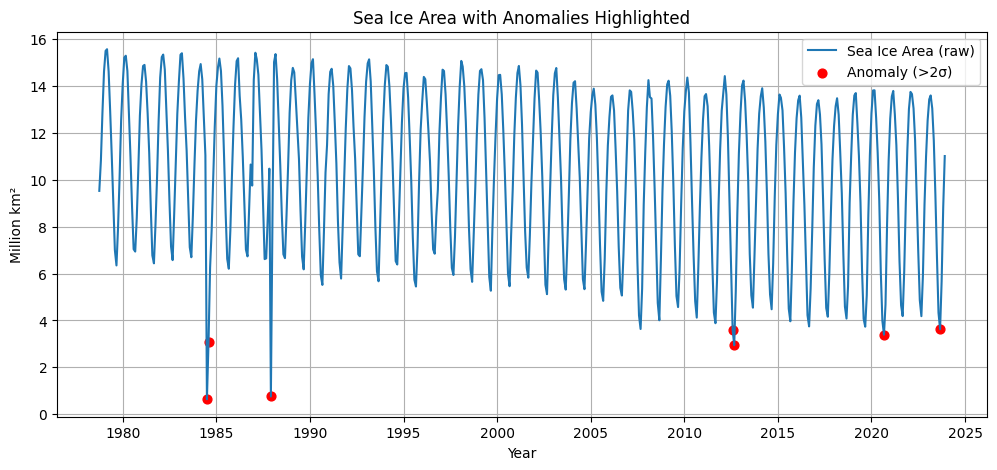

In [24]:
df_z = df_raw[["date", TARGET]].dropna().copy()
df_z["z"] = zscore(df_z[TARGET])
anoms = df_z[np.abs(df_z["z"]) > 2]

print(f"\n[Anomalies > 2σ]: {len(anoms)}")
print(anoms.head(10))

plt.figure(figsize=(12,5))
plt.plot(df_raw["date"], df_raw[TARGET], label="Sea Ice Area (raw)")
plt.scatter(anoms["date"], anoms[TARGET], label="Anomaly (>2σ)", s=40, color="red")
plt.title("Sea Ice Area with Anomalies Highlighted")
plt.xlabel("Year")
plt.ylabel("Million km²")
plt.legend()
plt.grid(True)
plt.show()

Step 8 – Pairplot for key variables

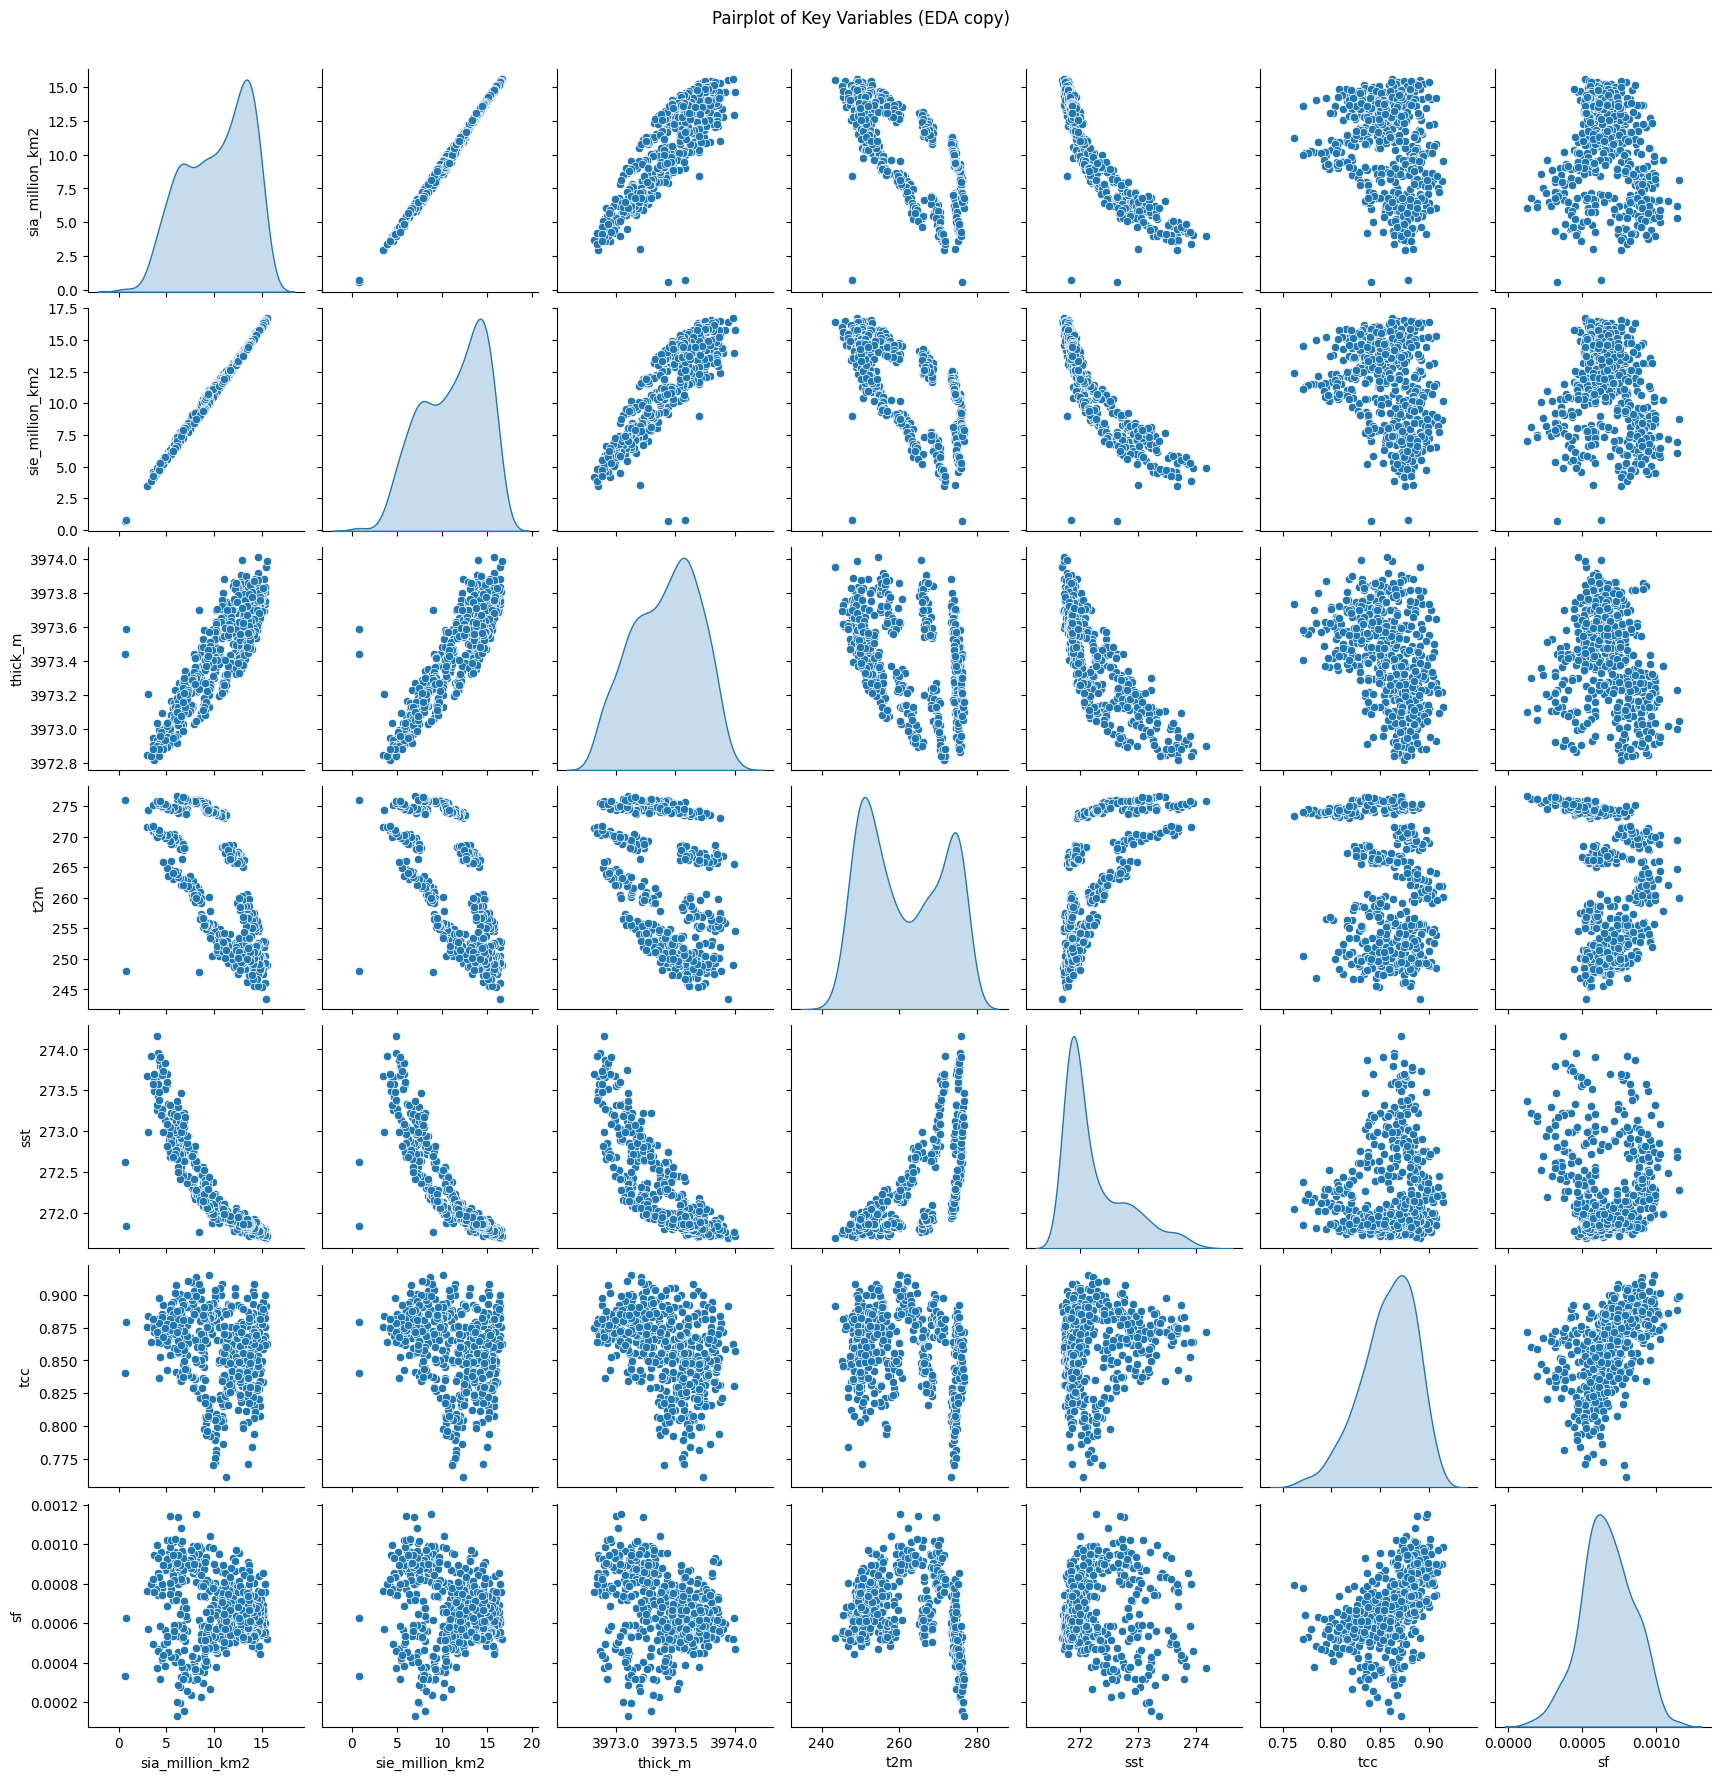

In [25]:
key_vars = [TARGET]
for c in ["sie_million_km2", "thick_m", "t2m", "sst", "tcc", "sf"]:
    if c in df_eda.columns:
        key_vars.append(c)

sns.pairplot(df_eda[key_vars], diag_kind="kde")
plt.suptitle("Pairplot of Key Variables (EDA copy)", y=1.02)
plt.show()